In [191]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [192]:
#import sys
#!{sys.executable} -m pip install -r requirements.txt

In [193]:
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.stattools import coint
from datetime import datetime
from datetime import timedelta

# just set the seed for the random number generator
#np.random.seed(107)

In [194]:
# Change...
pair = 'BTCUSDT'

# interval used to compute indicators and backtest analysis
# valid strategy intervals - 1min, 3min, 5min, 15min, 30min, 1H, 2H, 4H, 6H, 8H, 12H, 1D, 3D, 1W, 1M
strategy_interval = '1H'
# date to start/end analysis
dt_start_analysis = '2021-7-1'
# Use '' for analysis until now
dt_end_analysis = ''


In [195]:
from trade_utils import get_data

data = get_data(pair, strategy_interval)

In [196]:
data.shape

(34644, 5)

In [197]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34644 entries, 2017-08-17 04:00:00 to 2021-08-04 18:00:00
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   OpenPrice   34644 non-null  float64
 1   HighPrice   34644 non-null  float64
 2   LowPrice    34644 non-null  float64
 3   ClosePrice  34644 non-null  float64
 4   Volume      34644 non-null  float64
dtypes: float64(5)
memory usage: 1.6 MB


In [198]:
data.head()

,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume
OpenTime,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807


In [199]:
data.tail()

,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume
OpenTime,,,,,
2021-08-04 14:00:00,39013.01,39177.54,38850.00,39119.55,2871.843300
2021-08-04 15:00:00,39119.54,39472.47,39119.54,39302.00,3672.175116
2021-08-04 16:00:00,39302.00,39599.00,39240.20,39485.73,2772.249950
2021-08-04 17:00:00,39485.73,39495.00,39264.18,39390.21,1983.425700
2021-08-04 18:00:00,39390.21,39800.00,39383.51,39592.19,1171.993090


In [200]:
data.sample(10)

,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume
OpenTime,,,,,
2018-10-28 10:00:00,6491.80,6494.14,6483.00,6491.85,224.449381
2018-01-31 09:00:00,10239.64,10269.99,10060.00,10190.49,763.787430
2018-03-12 12:00:00,9837.04,9838.00,9752.01,9788.00,846.723163
2018-08-30 22:00:00,6942.12,6955.99,6922.00,6943.12,1457.606082
2020-10-22 04:00:00,12718.26,12800.00,12678.08,12752.50,2159.600749
2017-09-15 08:00:00,3148.00,3148.00,3002.01,3110.00,66.277838
2021-03-07 12:00:00,50705.52,50827.68,50391.19,50746.20,1924.672033
2021-05-27 23:00:00,38503.16,38755.51,38279.10,38529.98,2186.831763
2020-05-20 17:00:00,9497.99,9547.32,9441.99,9539.47,3661.460275


In [201]:
from technical_indicator_utils import sma, ema, macd, rsi, adx, bbands

# Calculate returns
data['Returns'] = data['ClosePrice'].pct_change() * 100 # pct_change() = percent change from previous price
data['Returns2'] = data['ClosePrice'].pct_change(2) * 100 # change from 2 previous price
data['Returns5'] = data['ClosePrice'].pct_change(5) * 100 # change from 5 previous price

# Volatility
data['volatility'] = data.rolling(24, min_periods = 24)['Returns'].std() * 100

# SMA
data['SMA5'] = sma(data['ClosePrice'], 5)
data['SMA10'] = sma(data['ClosePrice'], 10)
data['SMA20'] = sma(data['ClosePrice'], 20)
data['SMA30'] = sma(data['ClosePrice'], 30)
data['SMA50'] = sma(data['ClosePrice'], 50)
data['SMA100'] = sma(data['ClosePrice'], 100)
data['SMA200'] = sma(data['ClosePrice'], 200)

# EMA
data['EMA5'] = ema(data['ClosePrice'], 5)
data['EMA10'] = ema(data['ClosePrice'], 10)
data['EMA20'] = ema(data['ClosePrice'], 20)
data['EMA30'] = ema(data['ClosePrice'], 30)
data['EMA50'] = ema(data['ClosePrice'], 50)
data['EMA100'] = ema(data['ClosePrice'], 100)
data['EMA200'] = ema(data['ClosePrice'], 200)

# MACD
data['MACD'], data['MACDSignal'], data['MACDHist'] = macd(data.ClosePrice)

# RSI
data['RSI'] = rsi(data.ClosePrice)

# ADX
data['DI+'], data['DI-'], data['ADX'] = adx(data.HighPrice, data.LowPrice, data.ClosePrice)

# Bollinger Bands
data['UpperBBand'], data['MidiBBand'], data['LowerBBand'] = bbands(data.ClosePrice)

In [202]:
#limit data to plot
if dt_end_analysis == '':
    data = data[dt_start_analysis:]
else:
    data = data[dt_start_analysis:dt_end_analysis]

In [203]:
from technical_indicator_utils import fibonacci_retracement_levels

# Fibonacci retracement
fib_levels = fibonacci_retracement_levels(data['ClosePrice'].max(), data['ClosePrice'].min())

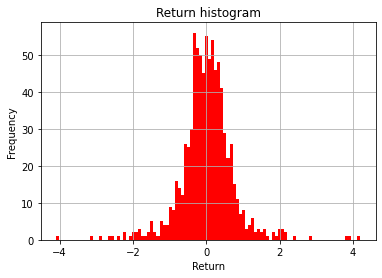

In [204]:
# Plot the histogram
data['Returns'].hist(bins=100, color='red')
plt.ylabel('Frequency')
plt.xlabel('Return')
plt.title('Return histogram')
plt.show()

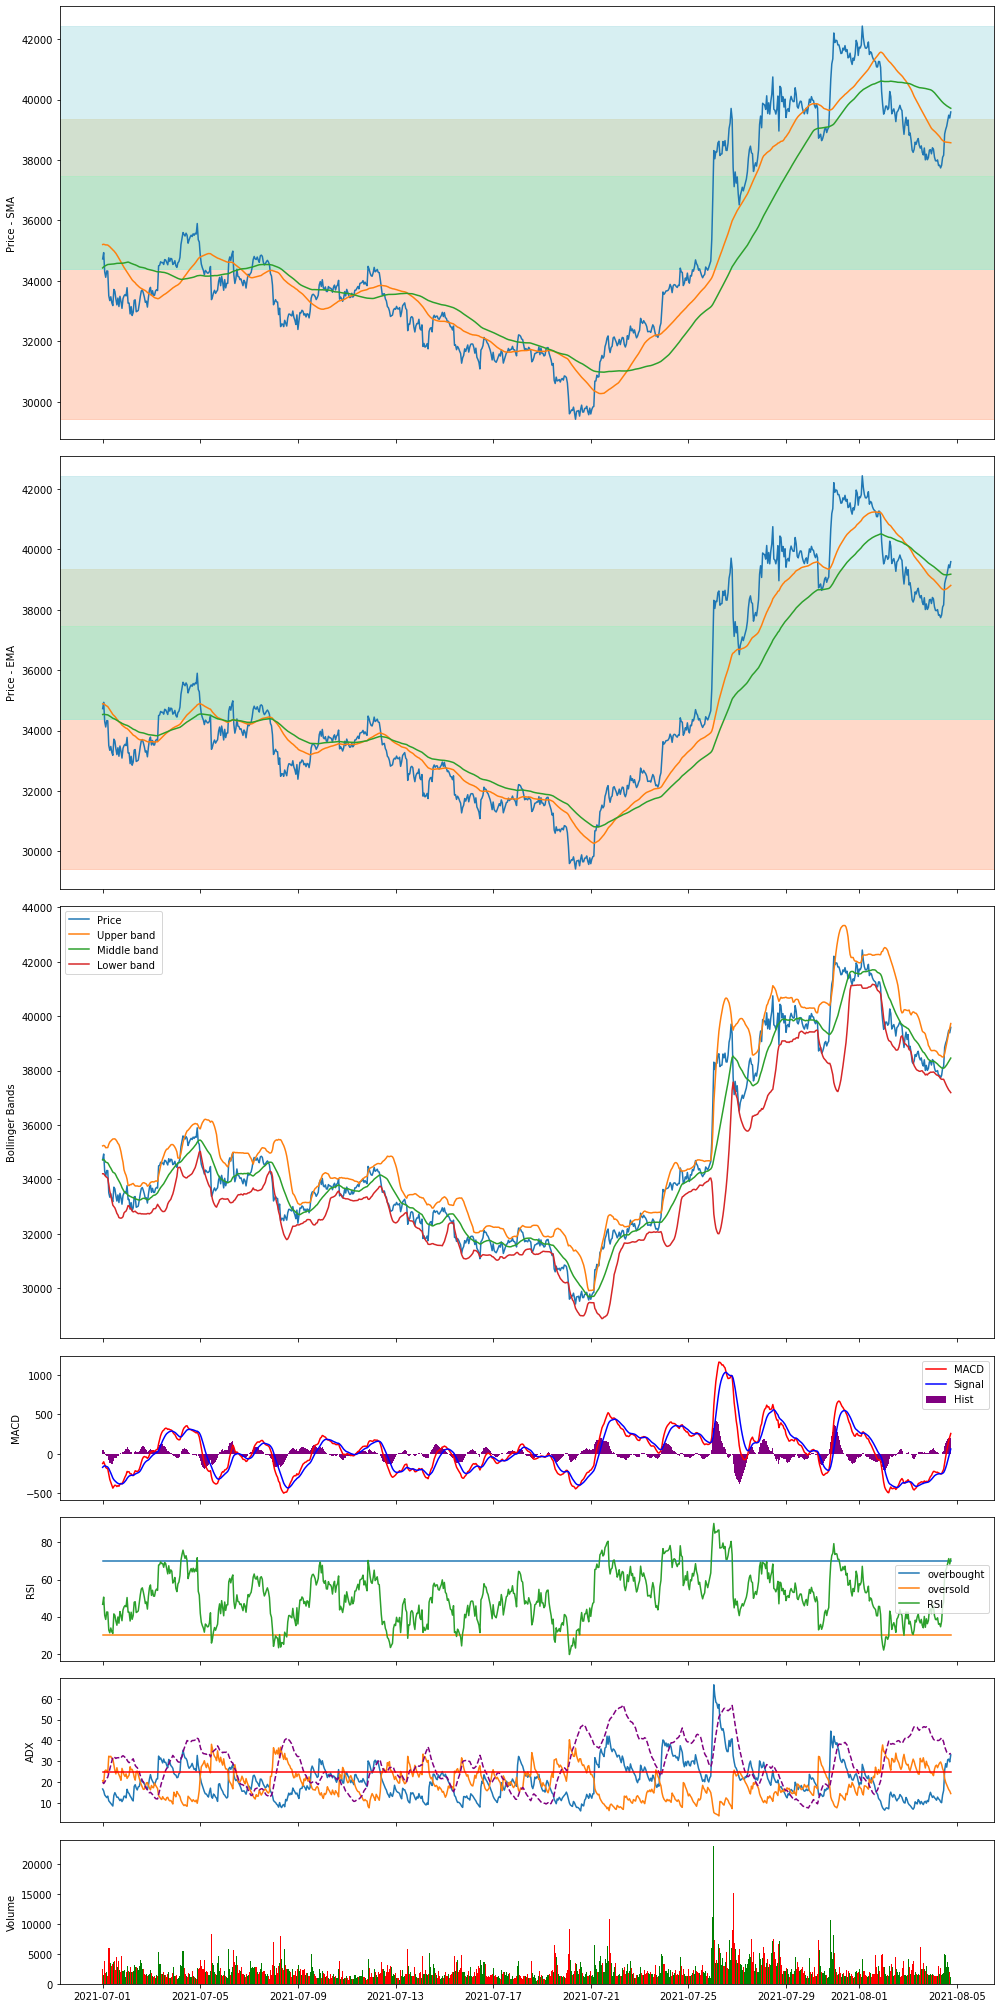

In [205]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(nrows=7, sharex=True, figsize=(14, 28), gridspec_kw = {'height_ratios':[3, 3, 3, 1, 1, 1, 1]})

# Price x SMA
ax1.plot(data.index, data[['ClosePrice', 'SMA50', 'SMA100']])
# Fibonacci retracement
ax1.axhspan(fib_levels['level1'], fib_levels['price_min'], alpha=0.4, color='lightsalmon')
ax1.axhspan(fib_levels['level2'], fib_levels['level1'], alpha=0.5, color='palegoldenrod')
ax1.axhspan(fib_levels['level3'], fib_levels['level2'], alpha=0.5, color='palegreen')
ax1.axhspan(fib_levels['price_max'], fib_levels['level3'], alpha=0.5, color='powderblue')
ax1.set_ylabel('Price - SMA')

# Price x EMA
ax2.plot(data.index, data[['ClosePrice', 'EMA50', 'EMA100']])
# Fibonacci retracement
ax2.axhspan(fib_levels['level1'], fib_levels['price_min'], alpha=0.4, color='lightsalmon')
ax2.axhspan(fib_levels['level2'], fib_levels['level1'], alpha=0.5, color='palegoldenrod')
ax2.axhspan(fib_levels['level3'], fib_levels['level2'], alpha=0.5, color='palegreen')
ax2.axhspan(fib_levels['price_max'], fib_levels['level3'], alpha=0.5, color='powderblue')
ax2.set_ylabel('Price - EMA')

# Bollinger Bands
ax3.plot(data['ClosePrice'], label='Price')
ax3.plot(data['UpperBBand'], label='Upper band')
ax3.plot(data['MidiBBand'], label='Middle band')
ax3.plot(data['LowerBBand'], label='Lower band')
ax3.legend()
ax3.set_ylabel('Bollinger Bands')

# MACD
ax4.plot(data.index, data['MACD'], label='MACD', color = 'red')
ax4.bar(data.index, data['MACDHist'], label='Hist', color="purple", width = timedelta(hours=1))
ax4.plot(data.index, data['MACDSignal'], label='Signal', color='blue')
ax4.legend()
ax4.set_ylabel('MACD')

# RSI
ax5.plot(data.index, [70] * len(data.index), label='overbought')
ax5.plot(data.index, [30] * len(data.index), label='oversold')
ax5.plot(data.index, data['RSI'], label='RSI')
ax5.legend()
ax5.set_ylabel('RSI')

# ADX
ax6.plot(data.index, data[['DI+', 'DI-']])
ax6.plot(data.index, data[['ADX']], color='purple', linestyle='dashed')
ax6.plot(data.index, [25] * len(data.index), color = 'red')
ax6.set_ylabel('ADX')

# Volume
# make bar plots and color differently depending on up/down for the day
pos = data['OpenPrice'] - data['ClosePrice'] < 0
neg = data['OpenPrice'] - data['ClosePrice'] > 0
ax7.bar(data.index[pos], data[pos]['Volume'], color='green', width = timedelta(hours=1))
ax7.bar(data.index[neg], data[neg]['Volume'], color='red', width = timedelta(hours=1))

#ax7.bar(data.index, data['Volume'] / 1000000, width = timedelta(hours=4))
ax7.set_ylabel('Volume')

fig.tight_layout()

## Backtest Strategy

In [206]:
import bt

# Get the price data
price_data = data[['ClosePrice']].copy()

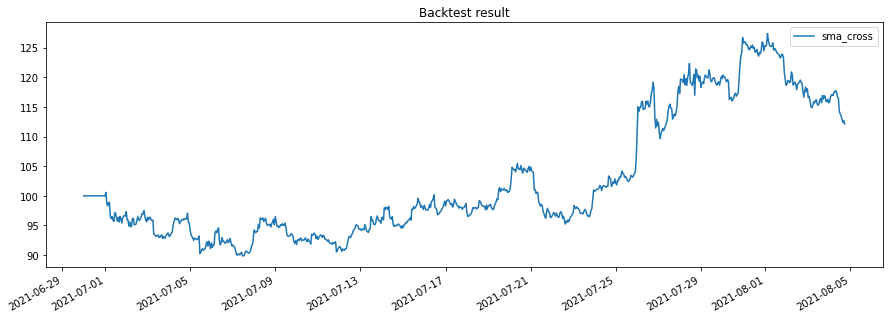

In [207]:
from backtest_utils import get_cross_signal, signal_strategy

signal = get_cross_signal(data[['SMA50']].copy(), data[['SMA200']].copy())
bt_sma_cross = signal_strategy(price_data.copy(), signal, 'sma_cross')

bt_result = bt.run(bt_sma_cross)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

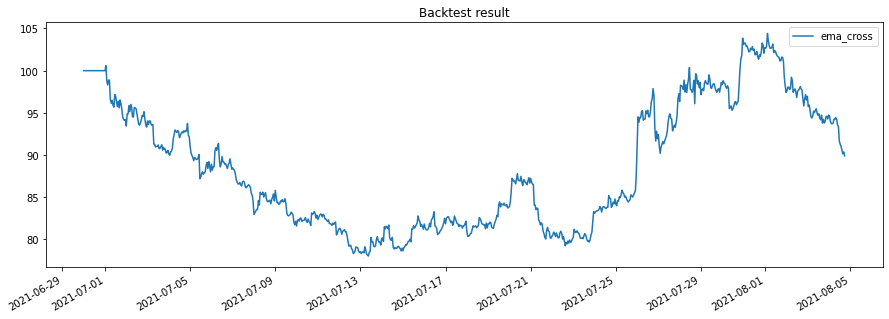

In [208]:
from backtest_utils import get_cross_signal, signal_strategy

signal = get_cross_signal(data[['EMA50']].copy(), data[['EMA200']].copy())
bt_ema_cross = signal_strategy(price_data.copy(), signal, 'ema_cross')

bt_result = bt.run(bt_ema_cross)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

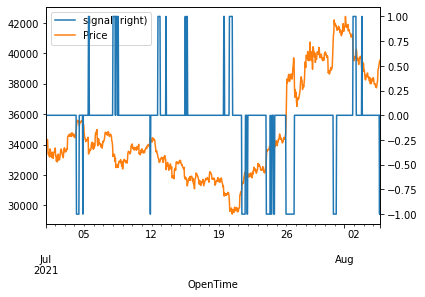

In [209]:
from backtest_utils import get_rsi_signal, signal_strategy

signal = get_rsi_signal(data[['RSI']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

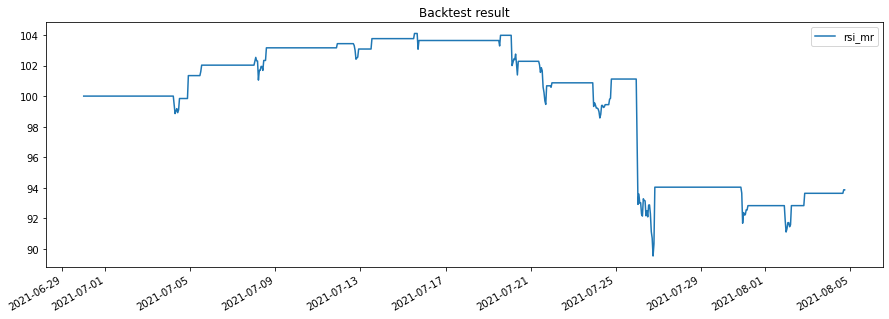

In [210]:
bt_rsi = signal_strategy(price_data.copy(), signal, 'rsi_mr')

bt_result = bt.run(bt_rsi)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

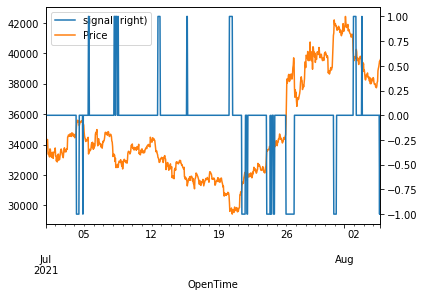

In [211]:
from backtest_utils import get_rsi_adx_signal, signal_strategy

signal = get_rsi_adx_signal(data[['RSI']].copy(), data[['ADX']])

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

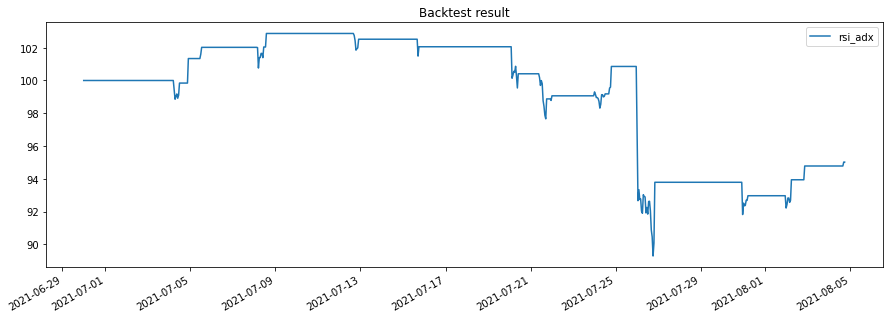

In [212]:
bt_rsi_adx = signal_strategy(price_data.copy(), signal, 'rsi_adx')

bt_result = bt.run(bt_rsi_adx)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

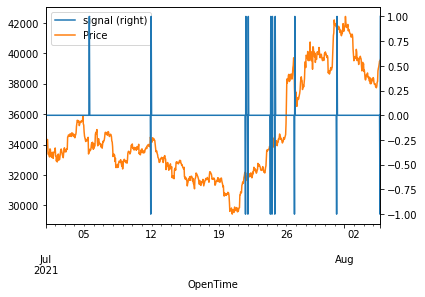

In [213]:
from backtest_utils import get_rsi_plus_signal, signal_strategy

signal = get_rsi_plus_signal(data[['RSI']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

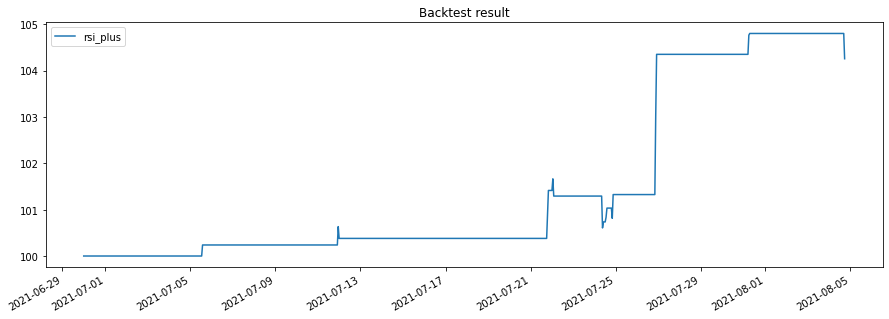

In [214]:
bt_rsi_plus = signal_strategy(price_data.copy(), signal, 'rsi_plus')

bt_result = bt.run(bt_rsi_plus)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

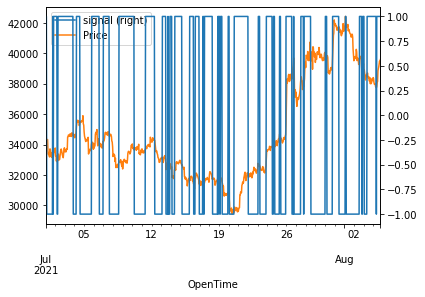

In [215]:
from backtest_utils import get_macd_signal, signal_strategy

signal = get_macd_signal(data[['MACDSignal']].copy(), data[['MACD']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

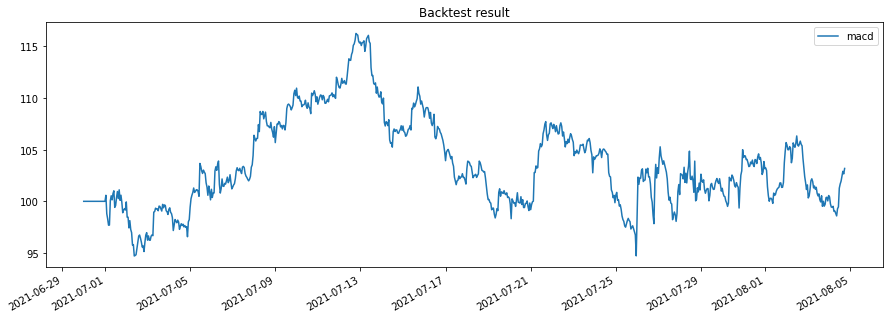

In [216]:
bt_macd = signal_strategy(price_data.copy(), signal, 'macd')

bt_result = bt.run(bt_macd)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

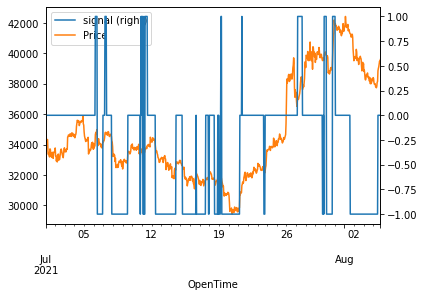

In [217]:
from backtest_utils import get_sma_macd_signal, signal_strategy

signal = get_sma_macd_signal(data[['ClosePrice']].copy(), data[['SMA50']].copy(), data[['SMA100']].copy(), data[['MACD']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

/home/evandro/.local/lib/python3.8/site-packages/ffn/core.py:2163: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/home/evandro/.local/lib/python3.8/site-packages/ffn/core.py:2163: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


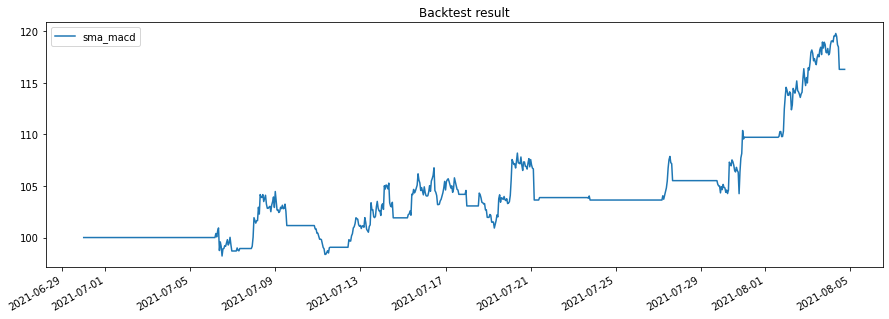

In [218]:
bt_sma_macd = signal_strategy(price_data.copy(), signal, 'sma_macd')

bt_result = bt.run(bt_sma_macd)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

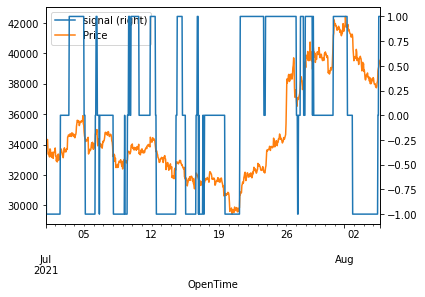

In [219]:
from backtest_utils import get_adx_macd_signal, signal_strategy

signal = get_adx_macd_signal(data[['MACD']].copy(), data[['DI+']].copy(), data[['DI-']].copy(), data[['ADX']].copy())

# Merge the data
combined_df = bt.merge(signal, price_data)
combined_df.columns = ['signal', 'Price']
combined_df.plot(secondary_y=['signal'])
plt.show()

/home/evandro/.local/lib/python3.8/site-packages/ffn/core.py:2163: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/home/evandro/.local/lib/python3.8/site-packages/ffn/core.py:2163: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


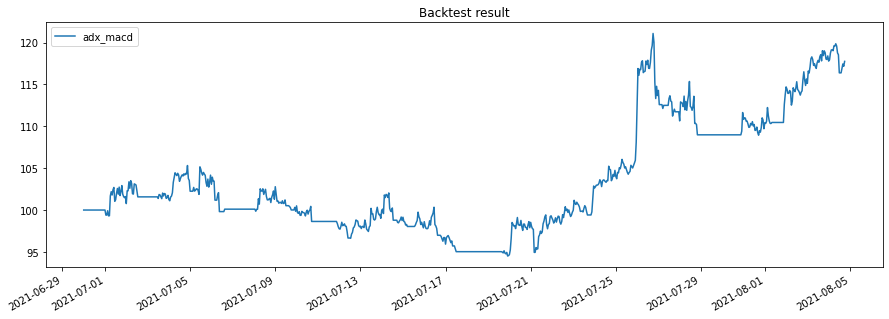

In [220]:
bt_adx_macd = signal_strategy(price_data.copy(), signal, 'adx_macd')

bt_result = bt.run(bt_adx_macd)
# Plot the backtest result
bt_result.plot(title='Backtest result')
plt.show()

In [221]:
from backtest_utils import signal_above_strategy, buy_and_hold_strategy

# Create signal strategy backtest
bt_sma5 = signal_above_strategy(price_data.copy(), data[['SMA5']].copy(), name='SMA5')
bt_sma10 = signal_above_strategy(price_data.copy(), data[['SMA10']].copy(), name='SMA10')
bt_sma20 = signal_above_strategy(price_data.copy(), data[['SMA20']].copy(), name='SMA20')
bt_sma30 = signal_above_strategy(price_data.copy(), data[['SMA30']].copy(), name='SMA30')
bt_sma50 = signal_above_strategy(price_data.copy(), data[['SMA50']].copy(), name='SMA50')
bt_sma100 = signal_above_strategy(price_data.copy(), data[['SMA100']].copy(), name='SMA100')

# Create benchmark strategy backtest
bt_benchmark = buy_and_hold_strategy(price_data.copy(), name='benchmark')

/home/evandro/.local/lib/python3.8/site-packages/ffn/core.py:2163: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/home/evandro/.local/lib/python3.8/site-packages/ffn/core.py:2163: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/home/evandro/.local/lib/python3.8/site-packages/ffn/core.py:2163: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/home/evandro/.local/lib/python3.8/site-packages/ffn/core.py:2163: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/home/evandro/.local/lib/python3.8/site-packages/ffn/core.py:2163: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/home/evandro/.local/lib/python3.8/site-packages/ffn/core.py:2163: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
/home/evandro/.local/lib/python3.8/site-packag

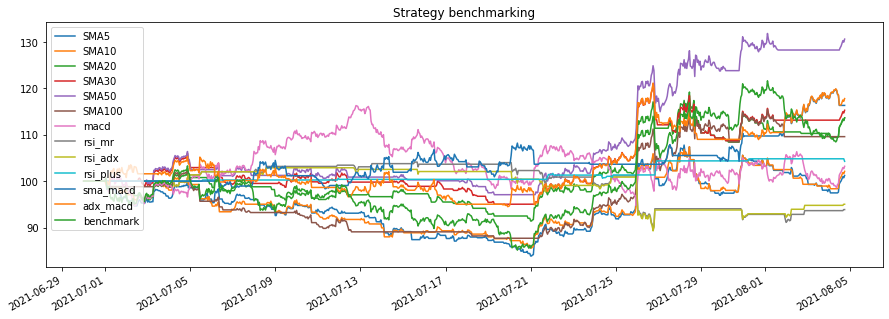

In [222]:
# Run all backtests and plot the resutls
bt_results = bt.run(bt_sma5,bt_sma10, bt_sma20, bt_sma30, bt_sma50, bt_sma100, bt_macd, bt_rsi, bt_rsi_adx, bt_rsi_plus, bt_sma_macd, bt_adx_macd, bt_benchmark)
#bt_results = bt.run(bt_rsi, bt_sma50, bt_benchmark)
bt_results.plot(title='Strategy benchmarking')
plt.show()

In [223]:
bt_results.display()

Stat                 SMA5        SMA10       SMA20       SMA30       SMA50       SMA100      macd        rsi_mr      rsi_adx     rsi_plus    sma_macd    adx_macd    benchmark
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  -----------
Start                2021-06-30  2021-06-30  2021-06-30  2021-06-30  2021-06-30  2021-06-30  2021-06-30  2021-06-30  2021-06-30  2021-06-30  2021-06-30  2021-06-30  2021-06-30
End                  2021-08-04  2021-08-04  2021-08-04  2021-08-04  2021-08-04  2021-08-04  2021-08-04  2021-08-04  2021-08-04  2021-08-04  2021-08-04  2021-08-04  2021-08-04
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         1.21%       2.10%       13.59%      15.24%      30.55%      9.57%       3.18%       -6.13%      -4.98% 

In [224]:
# Obtain all backtest stats
resInfo = bt_results.stats
ordered_strategies = resInfo.loc['total_return'].sort_values(ascending=False)
print(ordered_strategies)

best_strategy = ''
if resInfo.loc['total_return'].sort_values(ascending=False).index[0] == 'benchmark':
    best_strategy = resInfo.loc['total_return'].sort_values(ascending=False).index[1]
else:
    best_strategy = resInfo.loc['total_return'].sort_values(ascending=False).index[0]

bt_best = bt_results.backtests[best_strategy]

SMA50        0.305535
adx_macd     0.177562
sma_macd      0.16287
SMA30        0.152406
benchmark    0.136202
SMA20        0.135872
SMA100       0.095672
rsi_plus     0.042553
macd         0.031825
SMA10        0.021003
SMA5         0.012097
rsi_adx       -0.0498
rsi_mr      -0.061261
Name: total_return, dtype: object


/home/evandro/.local/lib/python3.8/site-packages/ffn/core.py:2163: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


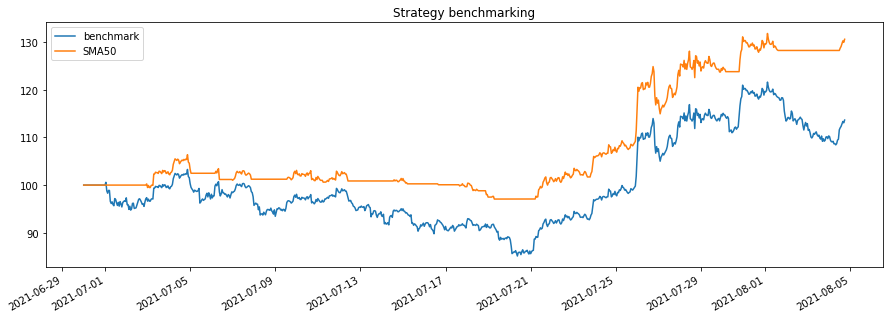

In [225]:
bt_results_best = bt.run(bt_benchmark, bt_best)
bt_results_best.plot(title='Strategy benchmarking')
plt.show()

In [226]:
bt_results_best.get_transactions(strategy_name=best_strategy)

,,price,quantity
Date,Security,,
2021-07-02 22:00:00,value,33703.04,29.0
2021-07-05 01:00:00,value,34558.05,-29.0
2021-07-06 04:00:00,value,34654.08,29.0
2021-07-06 09:00:00,value,34204.56,-29.0
2021-07-06 23:00:00,value,34220.01,29.0
2021-07-07 21:00:00,value,34239.86,-29.0
2021-07-09 13:00:00,value,33423.30,30.0
2021-07-10 20:00:00,value,33324.49,-30.0
2021-07-10 21:00:00,value,33428.57,30.0


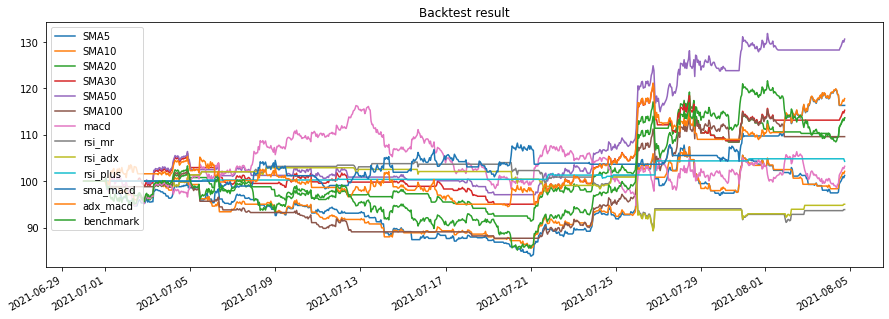

         SMA5   SMA10    SMA20    SMA30      SMA50   SMA100    macd   rsi_mr  \
mtd    -2.07%  -1.13%    2.13%    1.95%      1.40%   -2.86%  -0.64%    1.12%   
3m       nan%    nan%     nan%     nan%       nan%     nan%    nan%     nan%   
6m       nan%    nan%     nan%     nan%       nan%     nan%    nan%     nan%   
ytd     1.21%   2.10%   13.59%   15.24%     30.55%    9.57%   3.18%   -6.13%   
1y       nan%    nan%     nan%     nan%       nan%     nan%    nan%     nan%   
3y       nan%    nan%     nan%     nan%       nan%     nan%    nan%     nan%   
5y       nan%    nan%     nan%     nan%       nan%     nan%    nan%     nan%   
10y      nan%    nan%     nan%     nan%       nan%     nan%    nan%     nan%   
incep  13.37%  24.22%  277.92%  339.44%  1,515.60%  159.47%  38.67%  -48.30%   

       rsi_adx rsi_plus sma_macd adx_macd benchmark  
mtd      2.21%   -0.52%    6.00%    7.33%    -4.40%  
3m        nan%     nan%     nan%     nan%      nan%  
6m        nan%     nan%     nan%     

In [227]:
# Plot the backtest result
bt_results.plot(title='Backtest result')
plt.show()

# Get the lookback returns
lookback_returns = bt_results.display_lookback_returns()
print(lookback_returns)